# Grid-Search Hyperparameter Tuning

- What is hyper parameter
- How to tune and indentify optimal values for hyper parameters
- How to perform hyper parameter tuning in sklearn along with cross validation

In [21]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression



In [2]:
data = pd.read_csv('/Users/sylvia/Desktop/datasets/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [3]:
# Binary Variables - sex and smoker
data['sex'] = data['sex'].replace({'female':1, 'male':0})
data['smoker'] = data['smoker'].replace({'yes':1, 'no':0})
data.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,1,27.9,0,1,southwest,16884.92
1,18,0,33.8,1,0,southeast,1725.55
2,28,0,33.0,3,0,southeast,4449.46
3,33,0,22.7,0,0,northwest,21984.47
4,32,0,28.9,0,0,northwest,3866.86


In [4]:
# Multiclass variables - region
data_ohe = pd.get_dummies(data)
data_ohe = data_ohe.reindex(columns = [col for col in data_ohe.columns if col != 'expenses'] + ['expenses'])
data_ohe.head()


,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest,expenses
0,19,1,27.9,0,1,0,0,0,1,16884.92
1,18,0,33.8,1,0,0,0,1,0,1725.55
2,28,0,33.0,3,0,0,0,1,0,4449.46
3,33,0,22.7,0,0,0,1,0,0,21984.47
4,32,0,28.9,0,0,0,1,0,0,3866.86


**Split into Features and Target**

In [5]:
X = data_ohe.drop('expenses', axis = 1)
y = data_ohe['expenses']

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = .2, random_state=3)
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((1070, 9), (1070,), (268, 9), (268,))

**Modelling**

In [7]:
model = DecisionTreeRegressor(max_depth=7).fit(xtrain, ytrain) 

In [8]:
ypred_test = model.predict(xtest)

print('RMSE: %.2f' % np.sqrt(mean_squared_error(ytest, ypred_test)))
print('R2_score: %.2f' % (r2_score(ytest, ypred_test)))


RMSE: 5046.22
R2_score: 0.83


# Ways to find hyper-parameter (max_depth) values
## 1st - **Grid Search CV**

- Hyper-parameter : A parameter which has to be tuned based on the data we have 
- E.g -> min_samples_leaf, min_samples_split, max_depth or 
- Criteras like -> gini-impurity, entropy
- max_depth is one of the hyper parameter 
- max_depth has to be defined otherwise tree will be very large & complicated coz it tries to split every node which leads to  overfitting
- In above case max_depth is assumed to be 7


### GridSearchCV

#### Tuning single hyper parameter

Any parameter which we have to tune based on the data which we r picking is called as hyperparameter for the model. A ML model may have 1 or more hyperparameters.

Instead of we trying different decision trees with different max_depths values, we use scikit learn to make different decision trees with values specified in range as below.

In [9]:
# Specifying the range for max_depths to create multiple trees

# Initially this range is arbitrarily taken, its an iterative approach based on further analysis

params = {'max_depth':list(range(2,20))} 
params

{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]}

**Note**

1. For every max_depth, it will also do cross validation (as stated below cv=5) for e.g if we do cv=5 for max_depth=2, we will get mean R square for max_depth 2. Similary mean R square's for all depths & choose the depth with best mean R square.

2. Generally we fit on original model but now we fit on GridsearchCV model.
3. Only using training data in GridsearchCV model we try to identify optimal max_depth.

In [10]:
dtr = DecisionTreeRegressor()  # base model without any hyperparameter

gs_dtr = GridSearchCV(estimator=dtr, 
                      param_grid=params, # parameters in which we want to search optimal values
                      scoring='r2', 
                      cv=5).fit(xtrain, ytrain)

# After trying all depths b/w 2 and 20, it will pick the depth which has maximum r2 with cv.


In [11]:
gs_dtr.best_params_, gs_dtr.best_score_


({'max_depth': 4}, 0.8449212957688363)

To know results for all possibilities tried use cv_results_. By default dictionary is returned we can change it to dataframe for better view.

In [12]:
# If we want to know results of R2 scores for other max_depths use -> cv_results_
df_cv_results = pd.DataFrame(gs_dtr.cv_results_)
df_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001556,0.000390,0.000909,0.000136,2,{'max_depth': 2},0.857962,0.821586,0.799544,0.832458,0.774093,0.817129,0.028578,5
1,0.001390,0.000097,0.000766,0.000045,3,{'max_depth': 3},0.871974,0.840703,0.829108,0.860573,0.813413,0.843154,0.021080,2
2,0.001363,0.000009,0.000711,0.000004,4,{'max_depth': 4},0.874799,0.847134,0.823459,0.864164,0.815051,0.844921,0.022894,1
3,0.001496,0.000037,0.000718,0.000010,5,{'max_depth': 5},0.880109,0.841922,0.822264,0.851796,0.816724,0.842563,0.022694,3
4,0.001606,0.000012,0.000754,0.000042,6,{'max_depth': 6},0.859062,0.837866,0.799566,0.823369,0.835822,0.831137,0.019515,4
5,0.001783,0.000060,0.000754,0.000052,7,{'max_depth': 7},0.833180,0.837506,0.784606,0.780779,0.802978,0.807810,0.023740,6
6,0.001998,0.000118,0.000845,0.000202,8,{'max_depth': 8},0.803915,0.812578,0.765309,0.765556,0.743799,0.778232,0.025894,7
7,0.002139,0.000110,0.000817,0.000109,9,{'max_depth': 9},0.780181,0.793471,0.727017,0.691342,0.686359,0.735674,0.044257,8
8,0.002224,0.000023,0.000757,0.000031,10,{'max_depth': 10},0.762053,0.793784,0.744314,0.708558,0.614246,0.724591,0.061665,9
9,0.002344,0.000066,0.000768,0.000057,11,{'max_depth': 11},0.756660,0.762592,0.701063,0.688371,0.590568,0.699851,0.062032,10


In [13]:
# Best rank_test_score

df_cv_results.iloc[2]

mean_fit_time                0.001363
std_fit_time                 0.000009
mean_score_time              0.000711
std_score_time               0.000004
param_max_depth                     4
params               {'max_depth': 4}
split0_test_score            0.874799
split1_test_score            0.847134
split2_test_score            0.823459
split3_test_score            0.864164
split4_test_score            0.815051
mean_test_score              0.844921
std_test_score               0.022894
rank_test_score                     1
Name: 2, dtype: object

Above result has a rank of 1

In [14]:
# Next best

df_cv_results.iloc[1]

mean_fit_time                 0.00139
std_fit_time                 0.000097
mean_score_time              0.000766
std_score_time               0.000045
param_max_depth                     3
params               {'max_depth': 3}
split0_test_score            0.871974
split1_test_score            0.840703
split2_test_score            0.829108
split3_test_score            0.860573
split4_test_score            0.813413
mean_test_score              0.843154
std_test_score                0.02108
rank_test_score                     2
Name: 1, dtype: object

Above result has a rank of 2

####  By default we get only test scores but if we want training scores as well we need to add additional parameter 'return_train_score=True' 

In [15]:
gs_dtr1 = GridSearchCV(estimator=dtr,
                  param_grid=params, 
                  scoring='r2', cv=5, 
                  return_train_score=True).fit(xtrain, ytrain)

gs_dtr1.best_params_, gs_dtr1.best_score_


({'max_depth': 4}, 0.8449212957688363)

In [16]:
df_cv_results = pd.DataFrame(gs_dtr1.cv_results_)
df_cv_results.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.001317,0.000298,0.000805,0.000119,2,{'max_depth': 2},0.857962,0.821586,0.799544,0.832458,...,0.817129,0.028578,5,0.818996,0.827717,0.831257,0.823484,0.836264,0.827543,0.005990
1,0.001298,0.000049,0.000779,0.000073,3,{'max_depth': 3},0.871974,0.840703,0.829108,0.860573,...,0.843154,0.021080,2,0.848865,0.857754,0.860768,0.850968,0.862354,0.856142,0.005335
2,0.001384,0.000027,0.000735,0.000031,4,{'max_depth': 4},0.874799,0.847134,0.823459,0.864164,...,0.844921,0.022894,1,0.863599,0.869582,0.874635,0.868835,0.875272,0.870385,0.004267
3,0.001566,0.000089,0.000791,0.000115,5,{'max_depth': 5},0.880109,0.841922,0.822264,0.851796,...,0.842563,0.022694,3,0.875766,0.886687,0.889837,0.882796,0.885583,0.884134,0.004753
4,0.001648,0.000040,0.000766,0.000054,6,{'max_depth': 6},0.858673,0.837866,0.800473,0.823369,...,0.831243,0.019111,4,0.892347,0.901496,0.909180,0.898781,0.903215,0.901004,0.005511


# Plot mean train and test scores

In [17]:
mean_train_scores = df_cv_results['mean_train_score']
mean_test_scores   = df_cv_results['mean_test_score']
max_depths = df_cv_results['param_max_depth']

- When u increase depth of model, complexity of model will also increase.
- As complexity of model increases training score will always increase & then get saturated to certain portion e.g. below gets saturated at R2 score 1.We can understand training samples accurately cz R2 score=1 for training data.
- In test data, R2 score increase to certain point and then starts decreasing. So the point just before it starts to decrease is optimal point/depth.

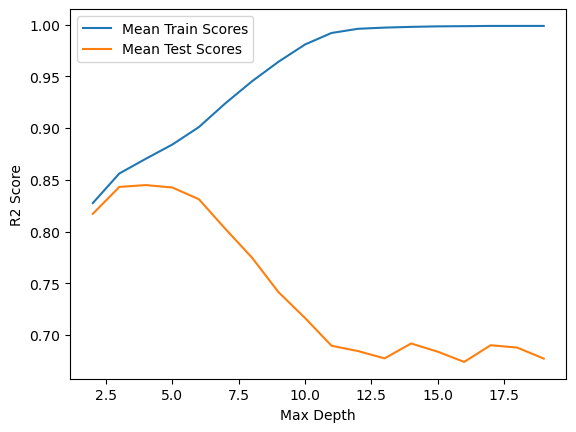

In [18]:
plt.plot(max_depths, mean_train_scores, label='Mean Train Scores')
plt.plot(max_depths, mean_test_scores, label ='Mean Test Scores')
plt.ylabel('R2 Score')
plt.xlabel('Max Depth')
plt.legend();

* Above chart implies how the train and test scores varies upon changes in max_depths
* max_depth below 4 could underfit 
* max_depth above 4 could overfit

**Hence either using this chart(qualitative) or using gs_dtr.best_params_(quantitative), can decide on best value of depth.**

- Usually best to look at both so u also include the human intuition into the picture & then decide. Sometimes just due to marginal increase in R square the default algorithm might rank a complex model as best model but when u visually look there could only be a marginal difference b/w a simple & complex model.
- In general we prefer a simple model over complex if improvement in score/performance is v.marginal.

## Predicting  with best estimator

You do not need to build model again with optimal hyperparameters in case u decide to go with Gridsearchcv model results, can use gs_dtr.best_estimator_ which is model fit with with best hyperparamters & can be directly used for prediction.

In [19]:
gs_dtr.best_estimator_

DecisionTreeRegressor(max_depth=4)

In [20]:
ypred_test = gs_dtr.best_estimator_.predict(xtest)
print('R2 Score : %.2f' % r2_score(ytest, ypred_test))

R2 Score : 0.87


**Conclusion**

Initially we got R2_score: 0.83 with default parameters and then using Gridsearchcv we got optimal depth=4 and increased performance to R2 Score : 0.87.